In [107]:
import numpy as np
import networkx as nx
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import factorial as facto
import time
rng = np.random.default_rng(seed=420)  # use Generator API

In [384]:
# Définition des fonctions

def theta_model(theta:np.ndarray, beta:np.ndarray):
    return 1-np.cos(theta)+np.multiply(1+np.cos(theta), beta)

def theta_model_scipy_solver(t, y:np.ndarray, beta, A:np.ndarray, n:int, beta_0:float, kappa:float):
    return 1-np.cos(y)+np.multiply(1+np.cos(y), beta(np.array([y]).T, A, n, beta_0, kappa).T[0])

def spike_rep(theta:np.ndarray, n = 2):
   return (1-np.cos(theta))**n

def beta_Vconst(beta:float, beta_switch:bool, beta_low:float = -0.01, beta_high:float = 0.01):
    if beta >= 0.2:
       beta_switch = False
    elif beta <= -0.3:
       beta_switch = True
    if beta_switch:
        return beta_switch, beta_high
    else:
        return beta_switch, beta_low

def beta_const(beta:float, beta_switch:bool):
   return False, 0

def dynamique_1_neurone(time_step:int, time_stop:int, theta_0:float, beta_0:float, theta_model, beta_model, *kwarg):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  beta_switch = True
  for _ in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[-1], beta[-1])
    beta_switch, Vbeta = beta_model(beta[-1], beta_switch, *kwarg)
    theta = np.concatenate((theta, theta[-1:]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[-1:]+Vbeta*time_step))
  return theta, beta

def beta2neurones(theta:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1): # point critique n:int = 1, seuil:float=-0.184151
   a_n = 2**n*(facto(n))**2/facto(2*n)
   # a_n = 1/2**(n+1)
   beta = spike_rep(theta, n)*a_n*kappa
   beta[[0, 1], :] = beta[[1, 0], :]
   return beta_0 + beta

def betaNneurones(theta_list:np.ndarray, A:np.ndarray, n:int = 2, beta_0:float=0, kappa:float = 1):
   N = len(theta_list)
   a_n = 2**n*(facto(n))**2/facto(2*n)
   if np.all(A == 1):
      beta1 = np.array([[np.sum(spike_rep(theta_list, n))]])
      beta = np.repeat(beta1, N, axis=0)
   else:
      beta = np.empty(np.shape(theta_list))
      for i in range(N):
         beta[i, 0] = np.sum(spike_rep(np.multiply(A[i], theta_list.T[0]), n))
   return beta_0 + a_n*kappa*beta/N

def dynamique_N_neurones(time_step:float, time_stop:int, theta_0:np.ndarray, theta_model, beta_model, *kwarg):
  N = len(theta_0)
  total_steps = int(time_stop/time_step)
  theta = np.empty((N, total_steps+1))
  beta = np.empty((N, total_steps+1))
  theta[:, 0:1] = theta_0
  beta[:, 0:1] = beta_model(theta_0, *kwarg)
  for step in range(1, total_steps+1):
   last_theta = theta[:, step-1:step]
   Vtheta = theta_model(last_theta, beta[:, step-1:step])
   new_theta = last_theta+Vtheta*time_step
   theta[:, step:step+1] = new_theta%(2*np.pi)
   beta[:, step:step+1] = beta_model(new_theta, *kwarg)
  return theta, beta

def indice_syncronisation(theta):
   return np.sqrt(np.sum(np.cos(theta), axis = 0)**2 + np.sum(np.sin(theta), axis = 0)**2)/len(theta)

def dist_lorentzienne(beta:np.ndarray, beta_0:float=0, gamma:float=0.1):
   return (gamma/np.pi)/((beta-beta_0)**2+gamma**2)

def true_samples(samples, beta_0, gamma):
   return beta_0+gamma*samples

def half_mean(data:np.ndarray, std:bool=False):
   if std:
      return (np.mean(data[int(len(data)/2):]), np.std(data[int(len(data)/2):]))
   return np.mean(data[int(len(data)/2):])

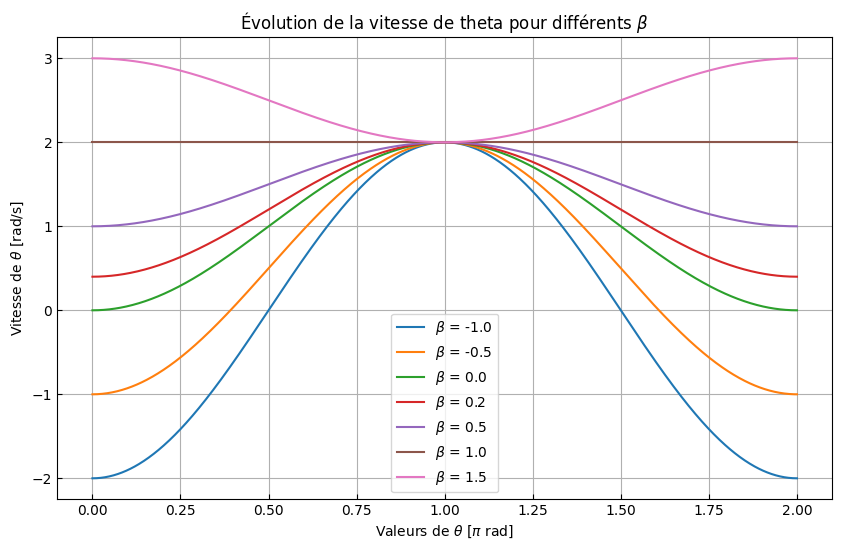

In [252]:
# Variation de la vitesse de theta selon theta pour plusieurs beta.
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-1, -0.5, 0, 0.2, 0.5, 1, 1.5])

plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list/np.pi, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Évolution de la vitesse de theta pour différents $\beta$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

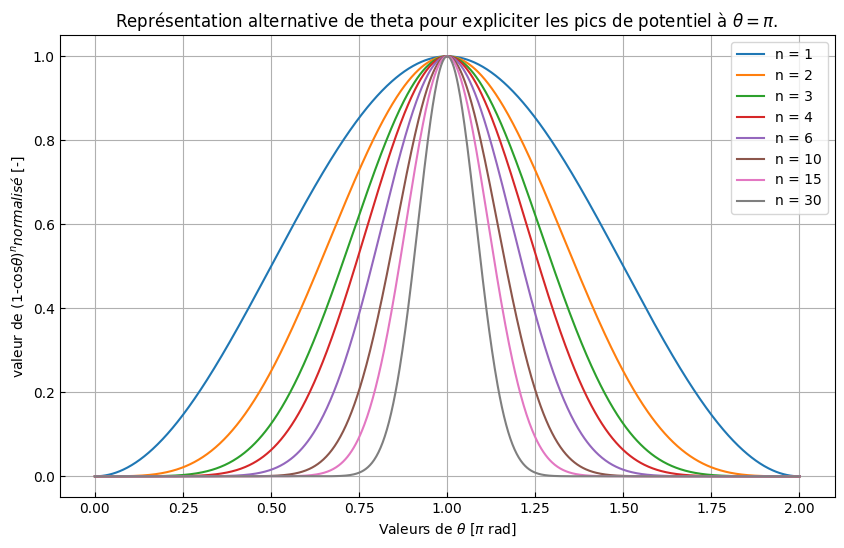

In [253]:
# Dynamique 1-cos(theta) et déffinition du pic
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])

plt.figure(figsize=(10, 6))
for i in spike_list:
  ydata = spike_rep(theta_list, i)
  plt.plot(theta_list/np.pi, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"valeur de (1-cos$\theta )^n normalisé$ [-]")
plt.title(r"Représentation alternative de theta pour expliciter les pics de potentiel à $\theta=\pi$.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

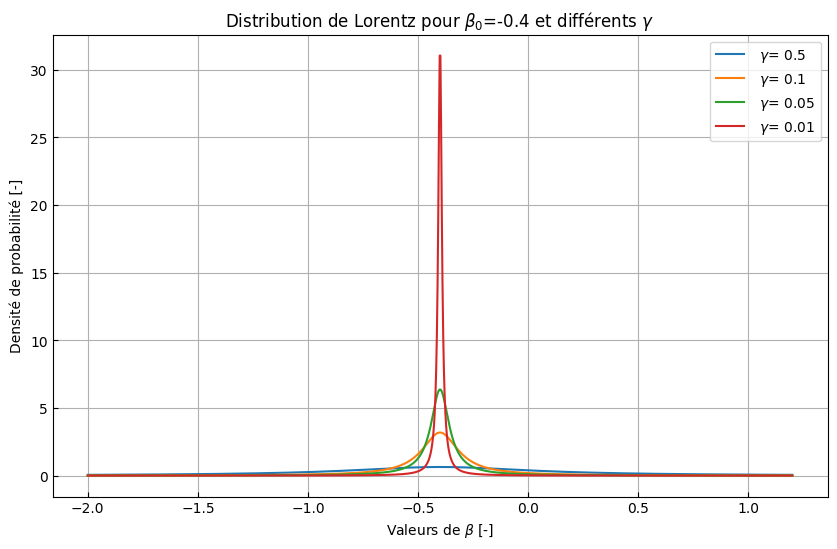

In [24]:
# distribution lorentzienne

gammas = np.array([0.5, 0.1, 0.05, 0.01])
beta_0 = -0.4
beta_list = np.linspace(-2, 1.2, 1000)

# beta_samples = true_samples(rng.standard_cauchy(size=1000), beta_0, gamma)
# betas = true_samples(np.random.standard_cauchy((1, 1000)), beta_0, gamma)

plt.figure(figsize=(10, 6))
for gamma in gammas:
    plt.plot(beta_list, dist_lorentzienne(beta_list, beta_0, gamma), label=fr' $\gamma$= {gamma}')
# plt.scatter(betas, dist_lorentzienne(betas, beta_0, gamma), s=2)
# plt.scatter(beta_samples, 3+dist_lorentzienne(beta_samples, beta_0, gamma), s=2)
plt.xlabel(r"Valeurs de $\beta$ [-]")
plt.ylabel(r"Densité de probabilité [-]")
plt.title(fr"Distribution de Lorentz pour $\beta_0$={beta_0} et différents $\gamma$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

theta = [0.00000000e+00 2.00000000e-03 4.00001800e-03 ... 6.29227294e+00
 6.29427331e+00 6.29627387e+00]
(1-cos($\theta$)$)^10$ = [0.00000000e+00 9.99996667e-61 1.04865639e-54 ... 1.40729927e-47
 7.52357248e-46 2.07574739e-44]


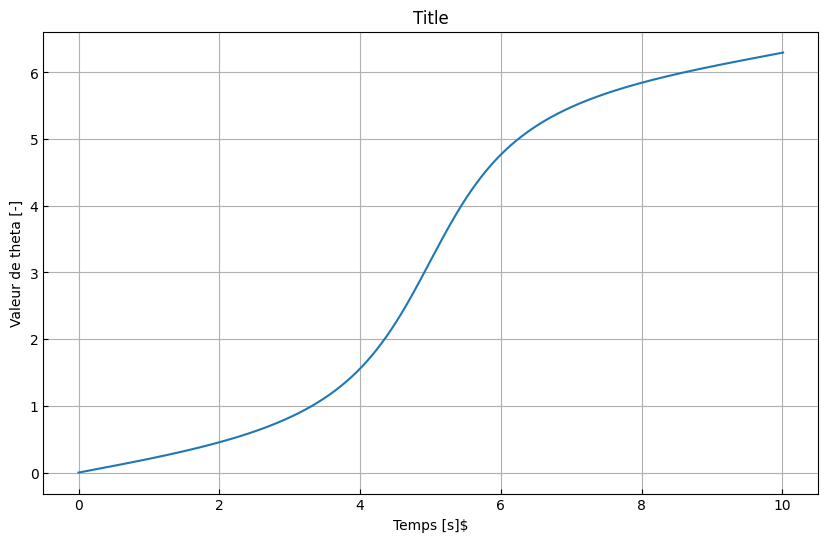

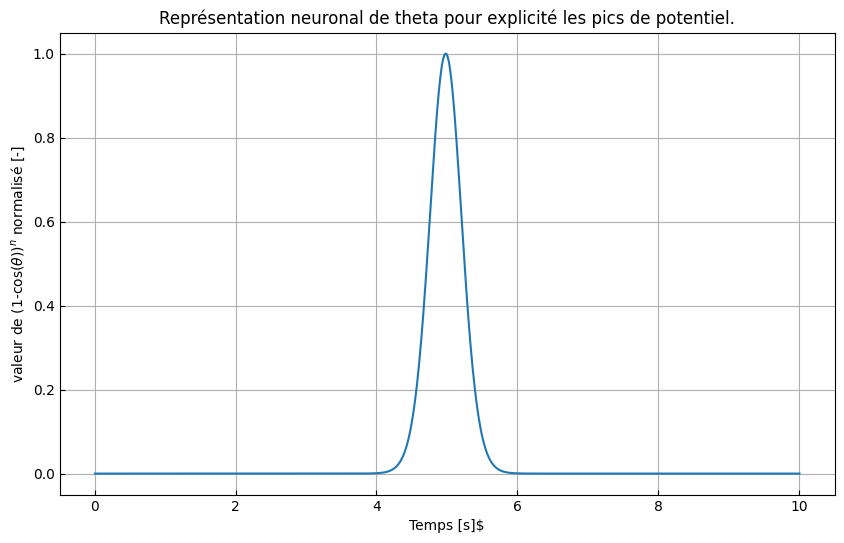

In [254]:
# Dynamique one spike  ---->  theta0 = 0      beta0 = 0.1    T = 10s
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

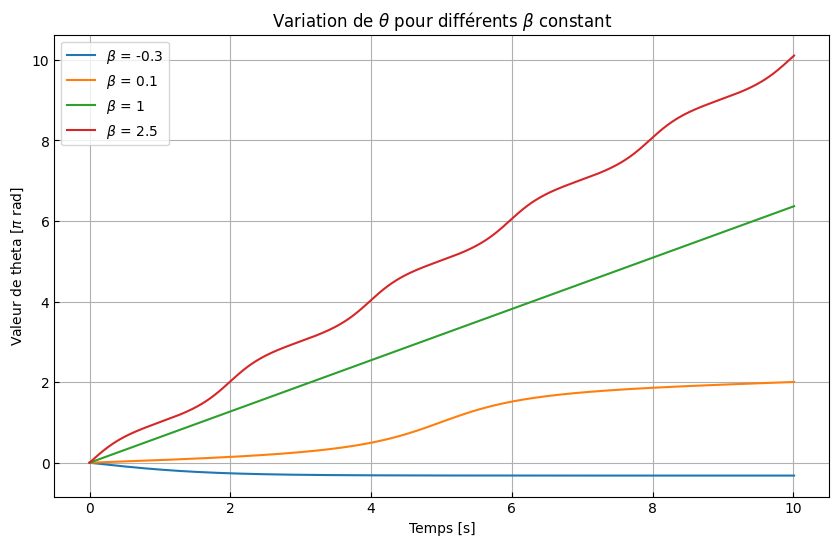

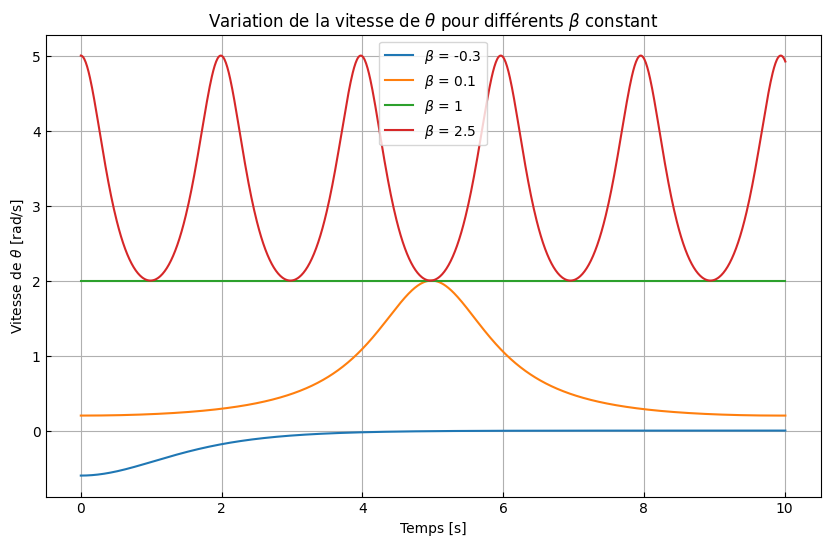

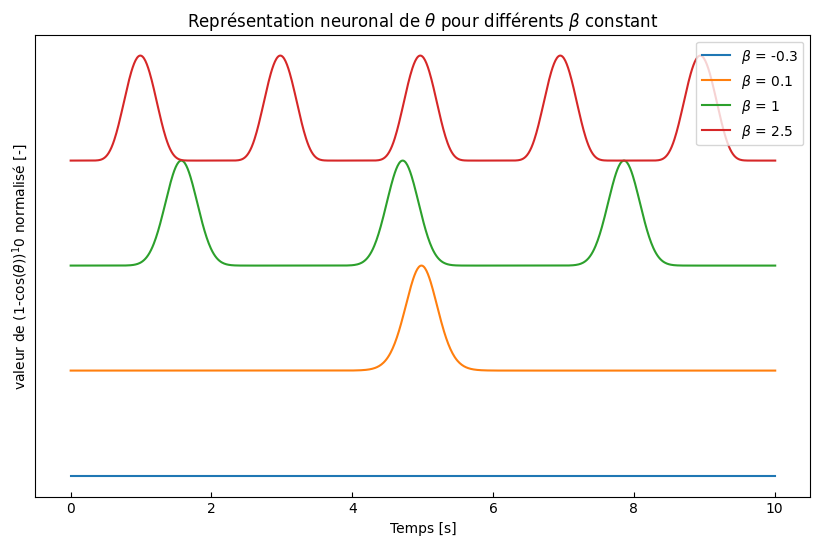

In [255]:
# Dynamique beta0 constant positif -----> effet sur theta  T = 10s
theta_0 = 0
beta_0_list = [-0.3, 0.1, 1, 2.5]

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta/np.pi, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de theta [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.yticks(ticks=[])
plt.show()

In [ ]:
# Dynamique beta oscillant entre 0.2 et -0.3 a vitesse constante.
theta_0 = 0
beta_0  = 0 # Interessant de voir l'effet sur la vitesse de theta quand beta0 = 1.5
time_start = 0
time_step = 0.01
time_stop = 300
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_Vconst, -0.01,  0.01)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fil du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta$ [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta, beta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour  $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta, 10)/2**10)
peaks, properties = find_peaks(spike_rep(theta, 30)/2**30, 0.5)
plt.scatter(time_list[peaks], properties['peak_heights'], c='red', s=15)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.show()




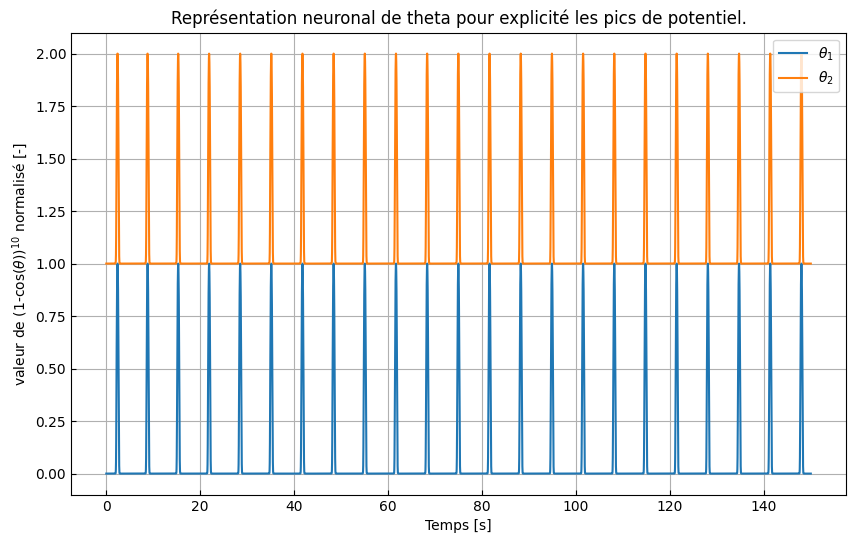

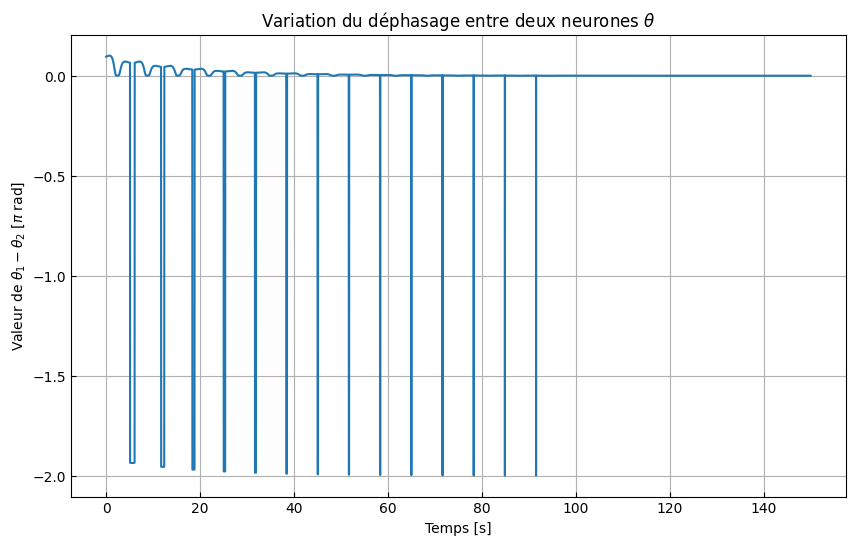

In [244]:
# Dynamique 2 neurones theta.
theta_0 = np.array([[0], [0.3]])
time_start = 0
time_step = 0.01
time_stop = 150
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, beta2neurones, 2, 0.1, 5)

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, beta[0], label = r'$\theta_1$')
# plt.plot(time_list, beta[1], label = r'$\theta_2$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta[0], 10)/2**10, label = r'$\theta_1$')
plt.plot(time_list, 1+spike_rep(theta[1], 10)/2**10, label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (theta[1]-theta[0])/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta_1-\theta_2$ [$\pi$ rad]")
plt.title(r"Variation du déphasage entre deux neurones $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, theta_model(theta[0], beta[0]))
# plt.plot(time_list, theta_model(theta[1], beta[1]))
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
# plt.title(r"Variation de la vitesse de $\theta$")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.show()

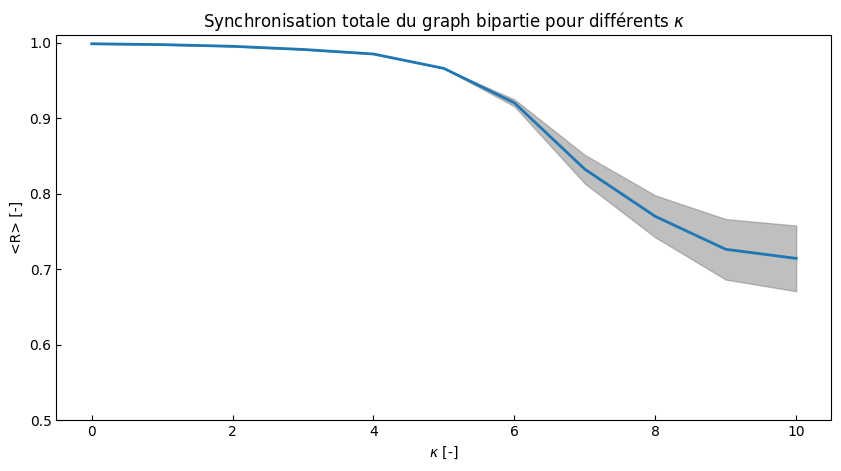

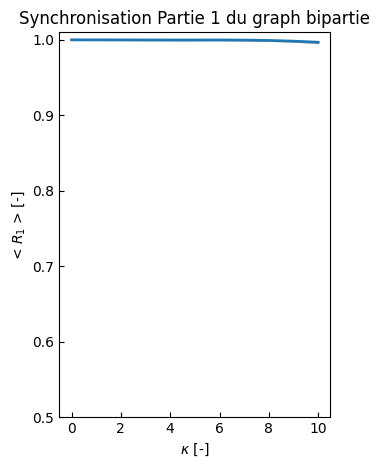

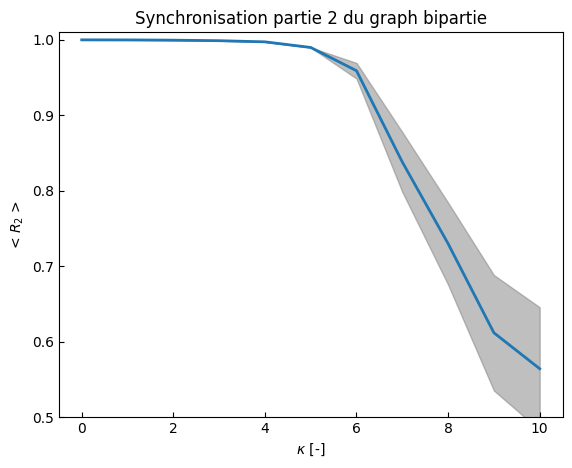

In [396]:
# test reproduction résultat Threefold way

graph = False
# kappas = [8]
kappas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# kappas = kappas[::2]
# mean = 5

# size = 250

# R_list = np.empty((len(kappas), 6))
# for i, kappa in enumerate(kappas):
#     R_mean_list = np.zeros((1, 6))

#     for _ in range(mean):
#         theta_0 = np.random.standard_normal((size, 1))

#         # A = np.ones((size, size))

#         G = nx.bipartite.random_graph(int(size*3/5), int(size*2/5), 0.2, directed=True)
#         A = np.array(nx.adjacency_matrix(G).toarray())

#         n = 1
#         beta_0 = np.concatenate((np.random.normal(-1.1, 0.0001, (int(size*3/5), 1)), np.random.normal(-0.9, 0.0001, (int(size*2/5), 1))), axis=0)
#         kappa = kappa


#         time_start = 0
#         time_step = 0.01
#         time_stop = 250
#         time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


#         # theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, n, beta_0, kappa)
#         sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=0.000001, max_step=1, atol = 0, rtol = 1e-10, args = (betaNneurones, A, n, beta_0, kappa))
#         theta, time_list = sol.y, sol.t

#         synchro = indice_syncronisation(theta)
#         synchro35 = indice_syncronisation(theta[: int(size*3/5)])
#         synchro25 = indice_syncronisation(theta[- int(size*2/5)+1:])
#         R, std = half_mean(synchro, True)
#         R1, std1 = half_mean(synchro35, True)
#         R2, std2 = half_mean(synchro25, True)

#         R_mean_list += np.array([R, R1, R2, std, std1, std2])
#     R_list[i, :] = R_mean_list/mean
# print(R_list[-1, 0])

if not graph:
    plt.figure(figsize=(10, 5))
    plt.plot(kappas, R_list[:, 0], lw=2)#, label=f'<R>={R}'
    plt.fill_between(kappas, R_list[:, 0]+R_list[:, 3], R_list[:, 0]-R_list[:, 3], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Synchronisation totale du graph bipartie pour différents $\kappa$")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

    plt.figure(figsize=(3.5, 5))
    plt.plot(kappas, R_list[:, 1], lw=2)
    plt.fill_between(kappas, R_list[:, 1]+R_list[:, 4], R_list[:, 1]-R_list[:, 4], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r'< $R_1$ > [-]')
    plt.title(r"Synchronisation Partie 1 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

    plt.figure(figsize=(6.5, 5))
    plt.plot(kappas, R_list[:, 2], lw=2)
    plt.fill_between(kappas, R_list[:, 2]+R_list[:, 5], R_list[:, 2]-R_list[:, 5], alpha=0.5, color='grey')
    plt.xlabel(r"$\kappa$ [-]")
    plt.ylabel(r"< $R_2$ >")
    plt.title(r"Synchronisation partie 2 du graph bipartie")
    plt.tick_params(direction = 'in')
    plt.ylim(0.5, 1.01)
    plt.show()

if graph:
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro, label=f'<R>={R}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"<R> [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro35, label=fr'< R$>_1$={R1}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_1$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 1)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(time_list, synchro25, label=fr'< R$>_2$={R2}')#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"< R$>_2$ [-]")
    plt.title(r"Évolution de la synchronisation au fils du temps (groupe 2)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.legend()
    plt.show()


    raster_plot_array = []

    plt.figure(figsize=(10, 10))
    for i in range(len(theta_0)):
        spike_rep_list = spike_rep(theta[i], 30)/2**30
        plt.plot(time_list, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
        raster_plot_array += [time_list[find_peaks(spike_rep_list, 0.5)[0]]]
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
    plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    # plt.legend()
    plt.show()

    plt.figure(figsize=(15, 4))
    output = spike_rep(theta, 30)/2**30
    V_spike_mat = np.repeat(output, 10, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(fr"Temps [{time_step}s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Heat map d'émission de potentiel des neurones.")
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_array[::-1])
    plt.xlabel(fr"Temps [s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Raster plot des pics d'émission de potentiel des neurones.")
    plt.grid(True)
    # plt.margins(0)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

0.0009357454772301935
done2
2416


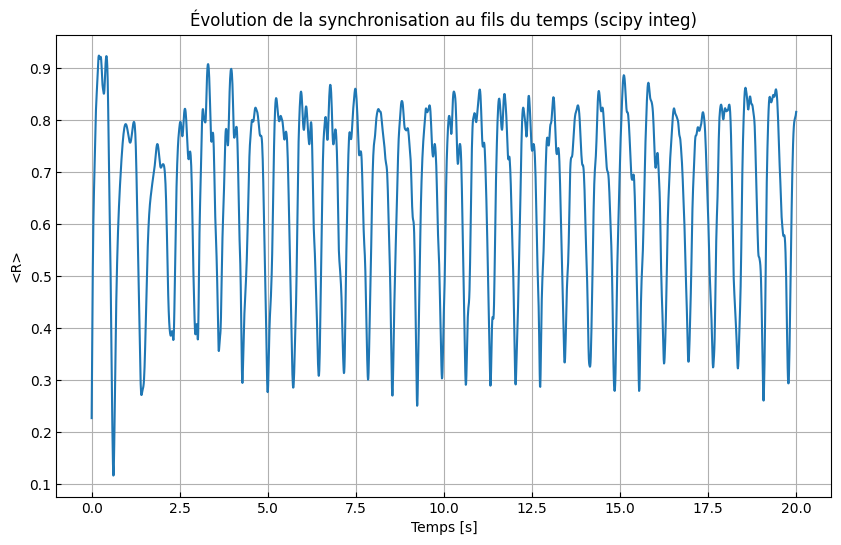

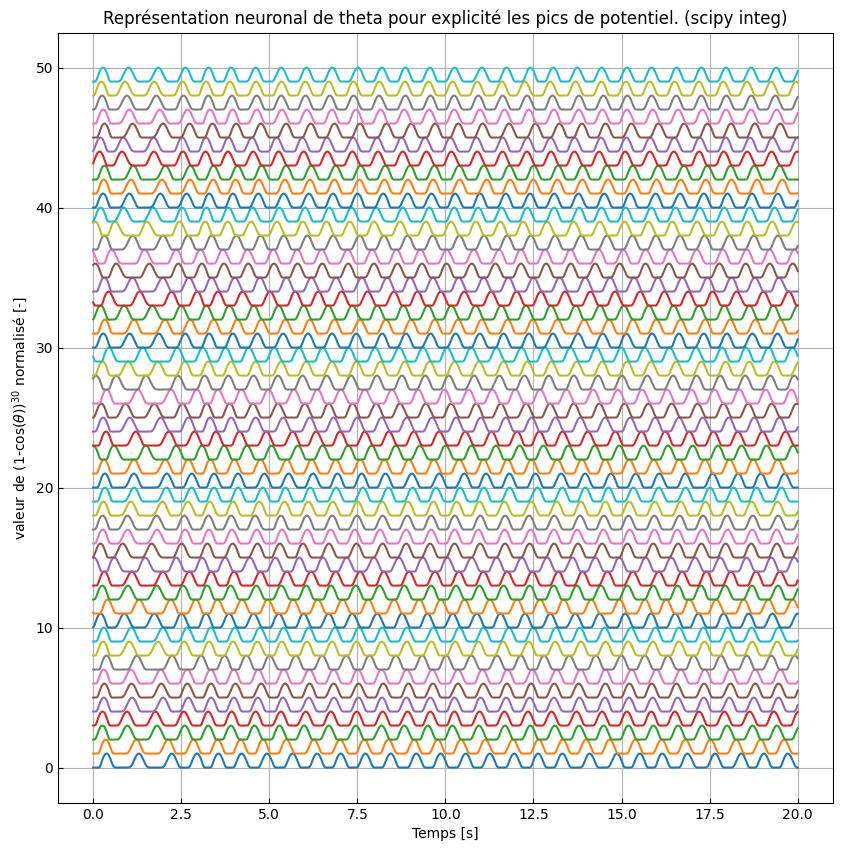

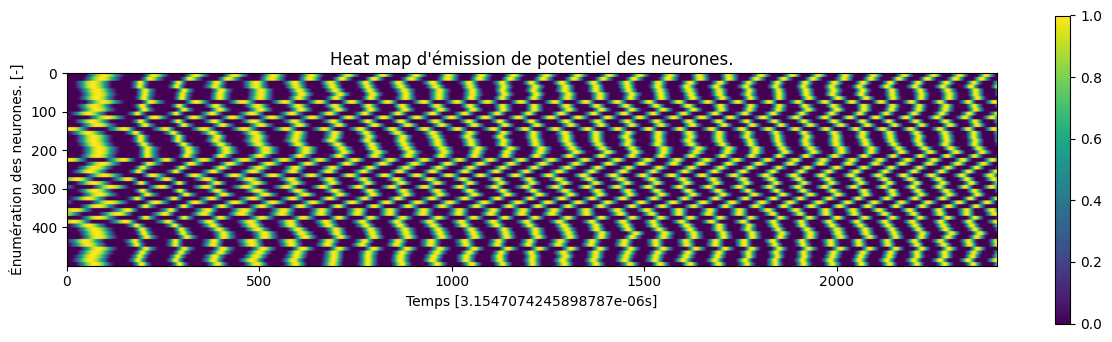

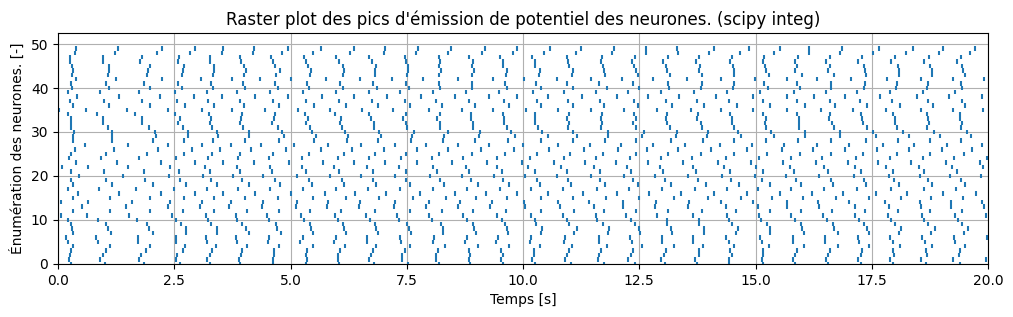

In [ ]:
# Dynamique N neurone theta.
size = 50

# Valeurs initials
# theta_0 = np.random.normal(np.pi, 0.1, (size, 1))
theta_0 = np.random.standard_normal((size, 1))
# theta_0 = np.random.rand(size, 1)*2*np.pi


# Matrice d'adjacence
# A = np.ones((size, size))-np.identity(size)
# A = np.random.normal(0.8, 0.05, (size, size))
G = nx.bipartite.random_graph(30, 20, 0.8)
A = np.array(nx.adjacency_matrix(G).toarray())

n = 2
beta_0 = 0.1
kappa = 20

a_n = 2**n*(facto(n))**2/facto(2*n)
step_approx = 0.1/(2*(beta_0 + a_n*kappa*2**n))
print(step_approx)

time_start = 0
time_step = step_approx
time_stop = 20
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

euler = 0
scipy = 1

if euler:
    theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, n, beta_0, kappa)
    print('done1')

if scipy:
    sol  = solve_ivp(theta_model_scipy_solver, [time_start, time_stop], theta_0.T[0], first_step=0.000001, max_step=1, atol = 1e-20, rtol = 1e-9, args = (betaNneurones, A, n, beta_0, kappa))
    print('done2')
    print(len(sol.t))

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, beta[0], 'ro', ms=1)
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.show()

if euler:
    plt.figure(figsize=(10, 6))
    plt.plot(time_list, indice_syncronisation(theta))#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"<R>")
    plt.title(r"Évolution de la synchronisation au fils du temps")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.show()


# Scipy version
if scipy:
    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, indice_syncronisation(sol.y))#, 'ro', ms=1
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"<R>")
    plt.title(r"Évolution de la synchronisation au fils du temps (scipy integ)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    plt.show()


raster_plot_array = []
raster_plot_scipy = []

if euler:
    plt.figure(figsize=(10, 10))
    for i in range(len(theta_0)):
        spike_rep_list = spike_rep(theta[i], 30)/2**30
        plt.plot(time_list, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
        raster_plot_array += [time_list[find_peaks(spike_rep_list, 0.5)[0]]]
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
    plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    # plt.legend()
    plt.show()


# scipy version
if scipy:
    plt.figure(figsize=(10, 10))
    for i in range(len(theta_0)):
        spike_rep_list = spike_rep(sol.y[i], 30)/2**30
        plt.plot(sol.t, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
        raster_plot_scipy += [sol.t[find_peaks(spike_rep_list, 0.5)[0]]]
    plt.xlabel(r"Temps [s]")
    plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
    plt.title("Représentation neuronal de theta pour explicité les pics de potentiel. (scipy integ)")
    plt.tick_params(direction = 'in')
    plt.grid(True)
    # plt.legend()
    plt.show()



if euler:
    plt.figure(figsize=(15, 4))
    output = spike_rep(theta[:, -20000:], 30)/2**30
    V_spike_mat = np.repeat(output, 10, axis=0)#1+int(time_stop/(len(theta_0)*8*time_step))
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(fr"Temps [{time_step}s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Heat map d'émission de potentiel des neurones.")
    plt.show()

if scipy:
    plt.figure(figsize=(15, 4))
    output = spike_rep(sol.y, 30)/2**30
    V_spike_mat = np.repeat(output, 10, axis=0)
    plt.imshow(V_spike_mat)
    plt.colorbar()
    plt.xlabel(fr"Temps [{2*np.mean(sol.t)/(len(sol.t)**2)}s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Heat map d'émission de potentiel des neurones.")
    plt.show()



if euler:
    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_array[::-1])
    plt.xlabel(fr"Temps [s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Raster plot des pics d'émission de potentiel des neurones.")
    plt.grid(True)
    # plt.margins(0)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

# Scipy version
if scipy:
    plt.figure(figsize=(12, 3))
    plt.eventplot(raster_plot_scipy[::-1])
    plt.xlabel(fr"Temps [s]")
    plt.ylabel(r"Énumération des neurones. [-]")
    plt.title(r"Raster plot des pics d'émission de potentiel des neurones. (scipy integ)")
    plt.grid(True)
    # plt.margins(0)
    plt.xlim(0, time_stop)
    plt.ylim(0)
    plt.show()

Networkx
- gnm
- Erdos-Renyi ++
- Configuration model

poid sompolinski

In [ ]:
# Erdos-Renyi exemple by Networkx
n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos, with_labels=True)
plt.show()

In [ ]:
# Configuration model exemple and try about multigraph plot (unsuccesful)
degree_list = [4, 7, 3, 6, 2, 3, 5, 2]
G = nx.configuration_model(degree_list)
graph_degree = int(sum(degree_list)/2)
print(G, graph_degree)

A = np.array(nx.adjacency_matrix(G).toarray())
print(np.sum(A+np.diag(np.diag(A)), axis=1))
print(list(G.edges))

plt.figure(figsize=(12, 6))
nx.draw_networkx(G, style=':', edge_color=tuple(np.linspace(0, 1, graph_degree)),  with_labels=True)
plt.show()

plt.imshow(A, cmap='plasma')
plt.colorbar()
plt.show()

In [ ]:
# Latex code for k_5 graph
G1 = nx.dense_gnm_random_graph(5, 10)
G = nx.complete_graph(5)
A = nx.adjacency_matrix(G)
print(np.array(A.toarray()))
nx.draw_shell(G, with_labels=True)
print(nx.to_latex(G, caption="Pentagrame"))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1]
 [1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 

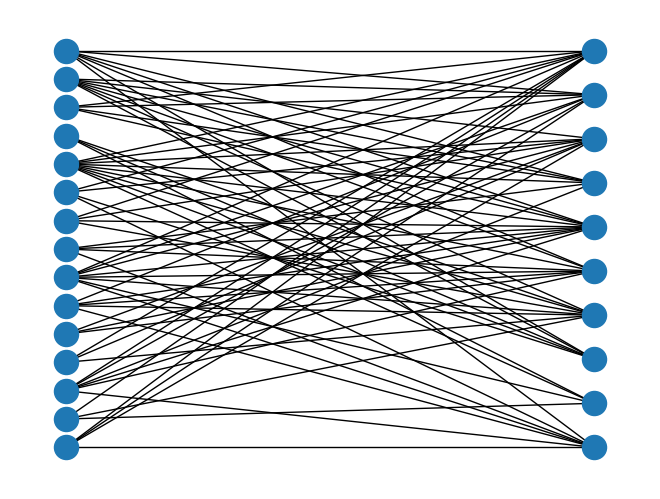

In [231]:
G = nx.bipartite.random_graph(15, 10, 0.5)
A = np.array(nx.adjacency_matrix(G).toarray())
print(A)
nx.draw_bipartite(G)